# импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import optuna

In [61]:

from tensorflow.keras.callbacks import EarlyStopping

# импорт данных

In [3]:
train_df=pd.read_csv('train_encoded.csv', sep = ';')
test_df=pd.read_csv('test_encoded.csv', sep = ';')

In [9]:
x_train = train_df.drop('Unit_Price', axis=1)
y_train = train_df['Unit_Price']
x_test = test_df.drop('Unit_Price', axis=1)
y_test = test_df['Unit_Price']

In [11]:
# Преобразование в numpy arrays
x_train = x_train.values
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

# модель MLP

In [13]:
# Создание модели MLP
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        
        layers.Dense(1)  # Выходной слой без активации для регрессии
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [15]:
# Создание и обучение модели
input_shape = x_train.shape[1]
model = build_model(input_shape)

# Ранняя остановка и сохранение лучшей модели
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)



C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 59s 20ms/step - loss: 8.1882 - mae: 2.1023 - val_loss: 0.4594 - val_mae: 0.4372
Epoch 2/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 38s 18ms/step - loss: 0.9036 - mae: 0.6910 - val_loss: 0.4637 - val_mae: 0.4385
Epoch 3/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.8412 - mae: 0.6659 - val_loss: 0.4444 - val_mae: 0.4250
Epoch 4/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.7671 - mae: 0.6282 - val_loss: 0.4325 - val_mae: 0.4220
Epoch 5/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.7469 - mae: 0.6274 - val_loss: 0.4355 - val_mae: 0.4190
Epoch 6/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.7544 - mae: 0.6298 - val_loss: 0.4289 - val_mae: 0.4191
Epoch 7/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.7053 - mae: 0.6021 - val_loss: 0.4223 - val_mae: 0.4132
Epoch 8/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.7469 - mae: 0.6184 - val_loss: 0.4210 - val_mae: 0.4157
Epoch 9/200
1733/1733

## оценка модели

In [16]:
# Оценка модели на тестовых данных
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Прогнозирование на тестовых данных
y_pred = model.predict(x_test).flatten()


Test MSE: 0.2974
Test MAE: 0.3212
929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [202]:
#функция для расчета всех метрик
def calculate_metrics(y_true, y_pred):
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # WAPE
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    
    return {
        'MAE': mae,
        'WAPE': wape}


metrics = calculate_metrics(y_test, y_pred)

In [203]:
metrics

{'MAE': 0.321245037589009, 'WAPE': 6.807082933304962}

## дф для сравнения результатов

In [206]:
# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Истинное значение': y_test,
    'Предсказанное значение': y_pred,
    'Разница': np.abs(y_test - y_pred),
    'Разница в %': np.abs((y_test - y_pred) / y_test) * 100  # в процентах
}).round(2)

results_df['Разница в %'] = results_df['Разница в %'].map('{:.2f}%'.format)

In [208]:
results_df.sample(20)

,Истинное значение,Предсказанное значение,Разница,Разница в %
27099,4.2,4.61,0.41,9.72%
22232,2.4,2.32,0.08,3.26%
16108,5.2,4.63,0.57,10.89%
14611,3.8,3.96,0.16,4.20%
25490,6.9,6.75,0.15,2.11%
6269,7.5,7.51,0.01,0.07%
23897,11.4,10.28,1.12,9.86%
18397,4.6,4.42,0.18,3.90%
13447,3.5,2.99,0.51,14.61%
6025,11.2,10.61,0.59,5.26%


## визуализация


In [211]:
def plot_deviations(results_df, sample_size=120):

        
    # Случайная выборка данных
    results_df_sample = results_df.sample(n=sample_size).reset_index(drop=True)
    
    # Создание графика отклонений
    plt.figure(figsize=(12, 6))
    
    # Точечные диаграммы
    plt.scatter(results_df_sample.index, results_df_sample['Истинное значение'], 
                label='Истинное значение', marker='o')
    plt.scatter(results_df_sample.index, results_df_sample['Предсказанное значение'], 
                label='Предсказанное значение', marker='x')
    
    # Соединение точек линиями
    for i in range(len(results_df_sample)):
        plt.plot([i, i], 
                 [results_df_sample['Истинное значение'][i], 
                  results_df_sample['Предсказанное значение'][i]], 
                 linestyle='--', color='gray', alpha=0.5)
    
    # Оформление графика
    plt.title(f'График отклонений ({sample_size} случайных значений): Истинные vs. Предсказанные значения')
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    
    plt.show()

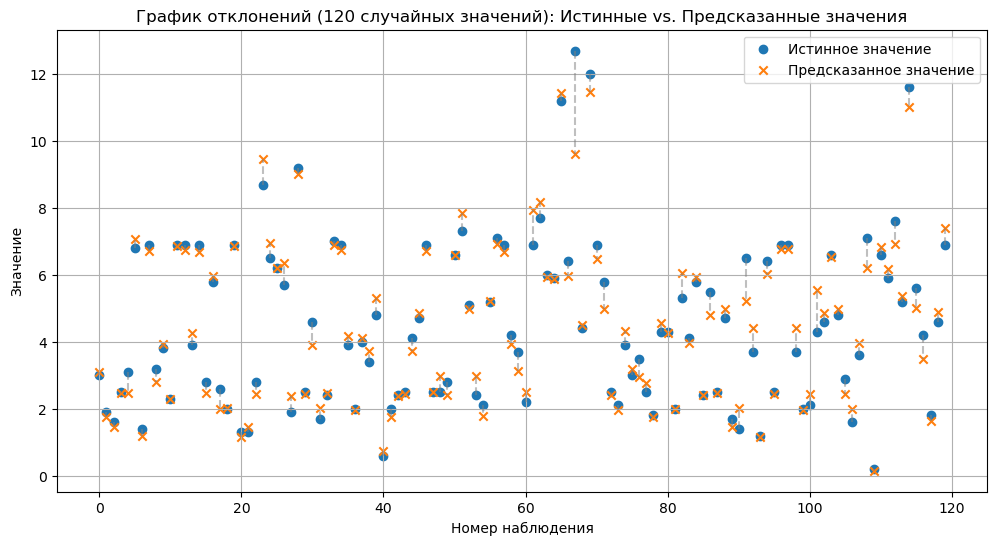

In [213]:
plot_deviations(results_df, 120)

## сохранение модели

In [95]:
# Сохранение в .h5 или SavedModel
model.save('mlp_model_1.keras')  

# подбор параметров с Optuna

In [71]:
# Функция для оптимизации с активацией
def objective(trial):
    params = {
        'hidden_units': trial.suggest_categorical('hidden_units', [[64, 32], [128, 64], [128, 64, 32]]),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.3),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'activation': trial.suggest_categorical('activation', ['relu', 'leaky_relu', 'elu'])
    }
    
    model = keras.Sequential()
    model.add(layers.Input(shape=(x_train.shape[1],)))
    
    for units in params['hidden_units']:
        model.add(layers.Dense(units, activation=params['activation']))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(params['dropout_rate']))
    
    model.add(layers.Dense(1))
    
    optimizer = keras.optimizers.Adam(
        learning_rate=params['learning_rate'],
        clipnorm=1.0
    )
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=params['batch_size'],
        callbacks=[EarlyStopping(patience=5)],
        verbose=0
    )
    
    return min(history.history['val_loss'])



In [73]:
# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=1800)  # 15 trials или 30 минут

# Вывод лучших параметров
print("Лучшие параметры:")
print(study.best_params)
print(f"Лучшее значение val_loss: {study.best_value:.4f}")



[I 2025-05-09 08:48:07,000] A new study created in memory with name: no-name-827f8c26-e76d-4474-aaff-c42bc0a26ab9
C:\Users\User\anaconda3\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 32] which is of type list.
  warnings.warn(message)
C:\Users\User\anaconda3\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64] which is of type list.
  warnings.warn(message)
C:\Users\User\anaconda3\Lib\site-packages\optuna\distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64, 32] which is of type list.
  warnings.warn(message)
[I 2025-05-09 08:56:37,601] Trial 0 finished with value: 0.39092567563056946

Лучшие параметры:
{'hidden_units': [64, 32], 'dropout_rate': 0.182848799671822, 'learning_rate': 0.00027156069329202623, 'batch_size': 32, 'activation': 'relu'}
Лучшее значение val_loss: 0.3619


## обучение модели на найденных параметрах

In [74]:
# Обучение финальной модели
best_params = study.best_params

final_model = keras.Sequential()
final_model.add(layers.Input(shape=(x_train.shape[1],)))

for units in best_params['hidden_units']:
    final_model.add(layers.Dense(units, activation=best_params['activation']))
    final_model.add(layers.BatchNormalization())
    final_model.add(layers.Dropout(best_params['dropout_rate']))

final_model.add(layers.Dense(1))

optimizer = keras.optimizers.Adam(
    learning_rate=best_params['learning_rate'],
    clipnorm=1.0
)
final_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = final_model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=best_params['batch_size'],
    callbacks=[
        EarlyStopping(patience=20, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)
    ],
    verbose=1)

Epoch 1/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 17.2740 - mae: 3.5439 - val_loss: 0.5652 - val_mae: 0.5240 - learning_rate: 2.7156e-04
Epoch 2/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.8949 - mae: 1.0553 - val_loss: 0.4656 - val_mae: 0.4519 - learning_rate: 2.7156e-04
Epoch 3/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1.4229 - mae: 0.8957 - val_loss: 0.4421 - val_mae: 0.4278 - learning_rate: 2.7156e-04
Epoch 4/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 1.2040 - mae: 0.8132 - val_loss: 0.4334 - val_mae: 0.4245 - learning_rate: 2.7156e-04
Epoch 5/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 1.1309 - mae: 0.7799 - val_loss: 0.4316 - val_mae: 0.4225 - learning_rate: 2.7156e-04
Epoch 6/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 1.0459 - mae: 0.7456 - val_loss: 0.4216 - val_mae: 0.4143 - learning_rate: 2.7156e-04
Epoch 7/200
1733/1733 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 0.9750 - mae: 0.7167 - val_loss: 0.42

## оценка модели

In [215]:
# Оценка
test_loss, test_mae = final_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest MSE: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test MSE: 0.3567
Test MAE: 0.3417


In [216]:
# Прогнозирование на тестовых данных
y_pred_2 = final_model.predict(x_test).flatten()

929/929 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [217]:
metrics_2 = calculate_metrics(y_test, y_pred_2)

In [218]:
metrics_2

{'MAE': 0.3417074829055003, 'WAPE': 7.240675817207426}

## сравнение результатов

In [220]:
# Создаем DataFrame с результатами
results_df_2 = pd.DataFrame({
    'Истинное значение': y_test,
    'Предсказанное значение': y_pred_2,
    'Разница': np.abs(y_test - y_pred_2),
    'Разница в %': np.abs((y_test - y_pred_2) / y_test) * 100  # в процентах
}).round(2)

results_df_2['Разница в %'] = results_df_2['Разница в %'].map('{:.2f}%'.format)

In [221]:
results_df_2.sample(20)

,Истинное значение,Предсказанное значение,Разница,Разница в %
23020,10.5,10.01,0.49,4.66%
338,4.3,3.91,0.39,9.17%
27420,3.8,3.98,0.18,4.80%
5849,6.9,6.88,0.02,0.23%
7329,0.9,1.07,0.17,19.21%
14604,5.4,4.90,0.50,9.25%
23755,2.0,1.94,0.06,2.75%
27843,2.5,2.49,0.01,0.37%
8477,4.4,4.72,0.32,7.38%
19148,9.4,10.08,0.68,7.27%


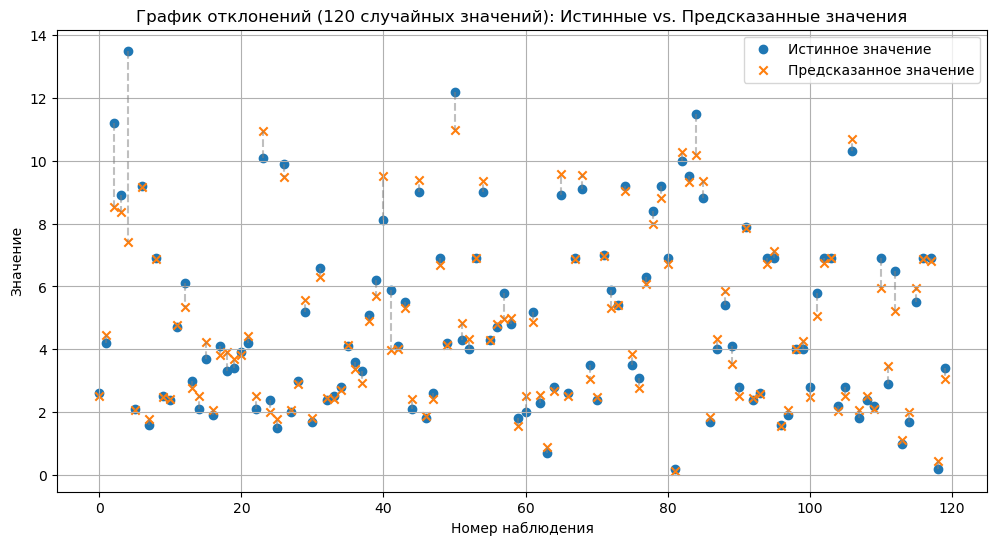

In [222]:
plot_deviations(results_df_2, 120)

## сохранение модели

In [97]:
# Сохранение в .h5 или SavedModel
model.save('mlp_model_2.keras')  

## cравнение моделей

In [225]:
# Создаем DataFrame
metrics_df = pd.DataFrame({
    'MLP': pd.Series(metrics),
    'MLP с Optuna': pd.Series(metrics_2)
})

# Добавляем столбец с разницей
metrics_df['Разница'] = metrics_df['MLP с Optuna'] - metrics_df['MLP']

# Добавляем процентное изменение
metrics_df['% изменения'] = (metrics_df['Разница'] / metrics_df['MLP']) * 100

# Форматируем значения с двумя знаками после запятой
metrics_df = metrics_df.round(2)

# Добавляем форматирование процентов
metrics_df['% изменения'] = metrics_df['% изменения'].map('{:.2f}%'.format)



In [226]:
metrics_df

,MLP,MLP с Optuna,Разница,% изменения
MAE,0.32,0.34,0.02,6.37%
WAPE,6.81,7.24,0.43,6.37%


In [227]:
import pandas as pd
import numpy as np

# Ваш первый DataFrame (MLP)
results_df = pd.DataFrame({
    'Истинное значение': y_test,
    'Предсказанное MLP': y_pred,
    'Разница MLP': np.abs(y_test - y_pred),
    'Разница в % MLP': np.abs((y_test - y_pred) / y_test) * 100
}).round(2)

results_df['Разница в % MLP'] = results_df['Разница в % MLP'].map('{:.2f}%'.format)

# Ваш второй DataFrame (MLP с Optuna)
results_df_2 = pd.DataFrame({
    'Предсказанное MLP с Optuna': y_pred_2,
    'Разница MLP с Optuna': np.abs(y_test - y_pred_2),
    'Разница в % MLP с Optuna': np.abs((y_test - y_pred_2) / y_test) * 100
}).round(2)

results_df_2['Разница в % MLP с Optuna'] = results_df_2['Разница в % MLP с Optuna'].map('{:.2f}%'.format)

# Объединяем оба DataFrame
results = pd.concat([results_df, results_df_2], axis=1)

# Добавляем столбцы с разницей между моделями
results['Разница между моделями'] = np.abs(results['Предсказанное MLP'] - results['Предсказанное MLP с Optuna'])
results['Разница в % между моделями'] = np.abs((results['Предсказанное MLP'] - results['Предсказанное MLP с Optuna']) / results['Истинное значение']) * 100

# Форматируем последний столбец
results['Разница в % между моделями'] = results['Разница в % между моделями'].map('{:.2f}%'.format)





In [228]:
results.sample(20)


,Истинное значение,Предсказанное MLP,Разница MLP,Разница в % MLP,Предсказанное MLP с Optuna,Разница MLP с Optuna,Разница в % MLP с Optuna,Разница между моделями,Разница в % между моделями
26465,6.9,6.71,0.19,2.70%,6.79,0.11,1.59%,0.080000,1.16%
9568,3.0,2.97,0.03,0.93%,3.01,0.01,0.32%,0.040000,1.33%
26168,0.8,0.95,0.15,18.15%,1.15,0.35,43.34%,0.200000,25.00%
2747,5.2,4.55,0.65,12.53%,4.52,0.68,13.12%,0.030000,0.58%
7301,5.2,4.40,0.80,15.39%,4.33,0.87,16.78%,0.070000,1.35%
10111,2.1,2.00,0.10,4.90%,2.09,0.01,0.70%,0.090000,4.29%
21853,2.6,2.50,0.10,3.95%,2.44,0.16,6.03%,0.060000,2.31%
28402,11.4,10.33,1.07,9.42%,10.02,1.38,12.12%,0.309999,2.72%
3293,6.9,6.81,0.09,1.38%,6.96,0.06,0.84%,0.150000,2.17%
24873,4.0,4.10,0.10,2.42%,4.06,0.06,1.47%,0.040000,1.00%


In [239]:
res_df = pd.DataFrame({
    'Истинное значение': y_test,
    'Предсказанное MLP': y_pred,
    'Предсказанное MLP с Optuna': y_pred_2,
}).round(2)

In [241]:
res_df

,Истинное значение,Предсказанное MLP,Предсказанное MLP с Optuna
0,7.5,7.47,7.65
1,5.4,5.36,5.25
2,3.1,2.99,3.04
3,5.1,4.61,4.77
4,8.1,7.66,7.42
...,...,...,...
29695,7.3,6.63,6.49
29696,2.4,2.98,2.99
29697,4.4,4.64,5.00
29698,10.2,9.45,9.33


In [243]:
res_df.to_csv('mlp_results.csv', sep = ';', index=True)